In [1]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import random
from collections import deque

class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995
        
		self.model = load_model("model/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay 

import numpy as np
import math
import io
import pandas as pd


# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
    vec = []
    lines=pd.read_csv('data/'+key+'.csv', sep=",", header=0).values
    for line in lines[1:]:
        vec.append(line[4])
    return vec

def getStockData(key):
    return pd.read_csv('data/'+key+'.csv', sep=",", header=0)

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])




Using TensorFlow backend.


In [2]:
import sys

sys.argv = ["AOT.BK",10,10]

stock_name, window_size, episode_count = sys.argv[0], int(sys.argv[1]), int(sys.argv[2])

agent = Agent(window_size)
data = getStockDataVec(stock_name)
rawData = getStockData(stock_name)
# l = len(data) - 1
l = 245
batch_size = 32

W0829 21:21:46.425745 4513609152 deprecation_wrapper.py:119] From /Users/watwattanagaroon/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 21:21:46.447446 4513609152 deprecation_wrapper.py:119] From /Users/watwattanagaroon/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 21:21:46.453181 4513609152 deprecation_wrapper.py:119] From /Users/watwattanagaroon/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 21:21:46.520730 4513609152 deprecation_wrapper.py:119] From /Users/watwattanagaroon/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Opti

/Users/watwattanagaroon/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


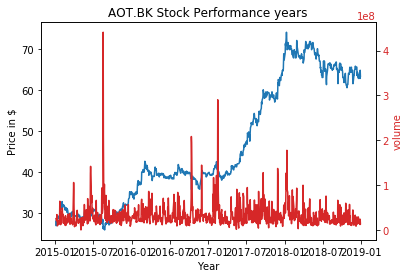

In [9]:
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline
# rawData['Date']=pd.to_datetime(rawData['Date'], format='%Y/%m/%d')
x2 = np.array(rawData['Date'])
y2 = rawData['Open']
y22= rawData['Volume']


plt.title(stock_name+" Stock Performance years")
plt.xlabel("Year")
plt.ylabel("Price in $")

plt.plot(x2,y2)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, y22, color=color)
ax2.tick_params(axis='y', labelcolor=color)




plt.show()

In [4]:
# import sys

# sys.argv = ["AOT.BK",10,1]

# stock_name, window_size, episode_count = sys.argv[0], int(sys.argv[1]), int(sys.argv[2])

# agent = Agent(window_size)
# data = getStockDataVec(stock_name)
# l = len(data) - 1
# # l = 245
# batch_size = 32

for e in range(episode_count + 1):
	print("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1)
	print(state)
	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)
		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			#print("Buy: " + formatPrice(data[t]))

		elif action == 2: # sell
			if len(agent.inventory) == 0:
				done = True
				reward = -100000                
			else:           
				bought_price = agent.inventory.pop(0)
				reward = max(data[t] - bought_price, 0)
				total_profit += data[t] - bought_price
			#print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print("--------------------------------")
			print("Total Profit: " + formatPrice(total_profit))
			print("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

	if e % 10 == 0:
		name = 'model/model_ep' + str(e)
		agent.model.save(name)

Episode 0/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: -$20.90
--------------------------------
Episode 1/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: $9.40
--------------------------------
Episode 2/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: $4.20
--------------------------------
Episode 3/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: -$3.00
--------------------------------
Episode 4/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: $2.20
--------------------------------
Episode 5/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: -$5.10
--------------------------------
Episode 6/10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
--------------------------------
Total Profit: $4.40
----------------------------

In [5]:
import keras
from keras.models import load_model

import sys

if len(sys.argv) != 3:
	print("Usage: python evaluate.py [stock] [model]")
	exit()
sys.argv = ['AOT.BK.Test','model_ep10']
stock_name, model_name = sys.argv[0], sys.argv[1]
model = load_model("model/" + model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32
print(window_size)
state = getState(data, 0, window_size + 1)
print(state)
total_profit = 0
agent.inventory = []
print(l)
for t in range(l):
	action = agent.act(state)
	print(str(t)+" "+str(action))
	# sit
	next_state = getState(data, t + 1, window_size + 1)
	reward = 0

	if action == 1: # buy
		agent.inventory.append(data[t])
		print("Buy: " + formatPrice(data[t]))

	elif action == 2 and len(agent.inventory) > 0: # sell
		bought_price = agent.inventory.pop(0)
		reward = max(data[t] - bought_price, 0)
		total_profit += data[t] - bought_price
		print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

	done = True if t == l - 1 else False
	agent.memory.append((state, action, reward, next_state, done))
	state = next_state

	if done:
		print(stock_name + " Total Profit: " + formatPrice(total_profit))
		print("--------------------------------")


10
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
61
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
AOT.BK.Test Total Profit: $0.00
--------------------------------
